<div align="center">
  <h1></h1>
  <h1>Universidad Nacional de Colombia</h1>
  <h2>Procesamiento del lenguaje natural</h2>
  <h2>Proyecto</h2>
  <h2>Dr Diomedes:
  <h3>Un Bot con sentimiento</h3>
  <h3>Grupo 1</h3>
  <strong>Estudiantes:</strong>  <br>
  Jhojan Sebastian Arango Castillo (<a href="mailto:jsarangoca@unal.edu.co">jsarangoca@unal.edu.co</a>) <br>
  Diego Andres Benitez Duarte (<a href="mailto:dabenitezd@unal.edu.co">dabenitezd@unal.edu.co</a>) <br>
  Jeraldine Muñoz Alvarado (<a href="mailto:jemunozal@unal.edu.co">jemunozal@unal.edu.co</a>) <br>
  Johan Sebastian Suarez Sepulveda (<a href="mailto:jemunozal@unal.edu.co">jssuarezse@unal.edu.co</a>) <br>
  <strong>Profesora:</strong> Elizabeth León Guzmán
</div>

# Etiquetado por reglas

En esta sección se establece un etiquetado donde, a partir de un listado de categorías, se identifican características en las letras de las canciones a partir de los elementos asociados en palabras comunes dentro del contenido de las letras, estableciendo esta clasificación por cada verso de la canción. El objetivo es asignar una etiqueta temática a cada verso de las canciones. Para ello, se ha definido un conjunto de categorías (como "amor", "familia", "nostalgia", etc.) y se ha asociado a cada una un listado de palabras representativas. El script recorre cada línea de las letras, la normaliza (convirtiéndola a minúsculas y quitando acentos) y busca la presencia de alguna de estas palabras clave. La primera coincidencia que encuentra determina la etiqueta del verso. Si ningún verso contiene palabras de las categorías definidas, se le asigna la etiqueta "otros". Este método es transparente, rápido y nos permite realizar una primera categorización temática del contenido.

In [2]:
import pandas as pd
import re
import unicodedata
from pathlib import Path

# ---------------------------
# Ajusta esta ruta a tu archivo
file_path = "/content/letras_musica_com_estructuradas_por_lineas.csv"
output_path = "/content/letras_etiquetadas_expandido.xlsx"
# ---------------------------

# Función para quitar acentos y normalizar texto
def quitar_acentos(texto):
    if texto is None:
        return ""
    texto = str(texto)
    texto = unicodedata.normalize("NFKD", texto)
    texto = "".join([c for c in texto if not unicodedata.combining(c)])
    return texto.lower()

# Lista de categorías y palabras (sin acentos)
categorias = {
    "amor": ["amor","querer","corazon","beso","quererte","novia","enamorar","pareja","amar","te amo","cariño","ternura","pasion","ilusion","sentimiento"],
    "familia": ["mama","papa","madre","padre","hijo","hija","hermano","hermana","nieto","abuelo","abuela","familia","hogar","crianza"],
    "infancia": ["nino","niñito","jugar","escuela","colegio","tarea","ninez","pequeno","inocencia","travesura","crecer","adolescencia"],
    "música": ["acordeon","cantar","cancion","musica","verso","nota","parranda","vallenato","melodia","ritmo","acordeonero","guitarra"],
    "tierra": ["junta","patillal","villanueva","pueblo","valledupar","tierra","patria","campo","lomas","sabanas","vereda","region","raiz","tradicion"],
    "nostalgia": ["recordar","recuerdo","volver","extrañar","añorar","anorar","memoria","pasado","vivencia","volver a recordar","regresar"],
    "fiesta": ["parranda","fiesta","alegria","baile","tomar","celebrar","rumba","brindar","juerga"],
    "naturaleza": ["rio","río","montana","montaña","mar","cielo","luna","sol","estrella","estrellas","campo","flor","flores","viento","amanecer","atardecer","noche"],
    "religión": ["dios","virgen","rezar","oracion","oración","milagro","fe","bendicion","bendición","santo","cristo","iglesia","alma","rezar"],
    "tristeza": ["triste","llorar","pena","dolor","lagrima","lágrima","soledad","sufrir","desdicha","angustia","perder","ausencia"],
    "vida": ["vida","vivir","existencia","camino","destino","futuro","tiempo","años","anos","mundo","andar","historia de vida"],
    "amistad": ["amigo","compadre","compadres","colega","amistad","hermano del alma","parcero","panita"],
    "trabajo": ["trabajo","esfuerzo","lucha","jornal","sacrificio","sudor","oficio","labrar"],
    "despedida": ["adios","adiós","despedida","lejos","partir","me voy","irse","se fue","se fue"],
    "costumbres": ["costumbre","tradicion","tradición","folclor","cultura","fiestas patronales","costumbres","ceremonia"],
    "consejos": ["consejo","enseñar","aprendizaje","recomendar","advertir","recomiendo","aconsejo","sugerencia"],
    "reflexiones": ["pienso","reflexion","reflexión","saber","entiendo","comprender","pensar","sabiduria","sabiduría","meditar"]
}

# Cargar DataFrame
df = pd.read_csv(file_path)

# Mostrar columnas detectadas (útil para debug)
print("Columnas del archivo:")
print(df.columns.tolist())

# Detectar columnas de verso: buscamos columnas que contengan 'linea' o 'letra' o 'verso' y un número
pattern = re.compile(r'(?i)\b(linea|letra|verso|line)\b.*\d')  # busca palabras + número
verse_cols = [c for c in df.columns if pattern.search(str(c))]

# Si no encuentra con ese patrón, intentar detectar columnas 'linea_1', 'linea1', 'linea 1' genéricamente
if not verse_cols:
    verse_cols = [c for c in df.columns if re.search(r'\d+$', str(c)) and 'line' in str(c).lower()]

print("\nColumnas detectadas como versos (se procesarán):")
print(verse_cols)

if not verse_cols:
    raise ValueError("No se detectaron columnas de versos automáticamente. "
                     "Asegúrate de que las columnas se llamen algo como 'linea_1', 'letra_linea_1' o 'verso_1'.")

# Función de clasificación
def clasificar_verso(verso):
    if pd.isna(verso):
        return ""  # o None si prefieres celda vacía
    texto = quitar_acentos(str(verso))
    texto = texto.lower()
    # buscar por categoría en el orden definido
    for etiqueta, palabras in categorias.items():
        for p in palabras:
            if p and p in texto:
                return etiqueta  # devuelve la etiqueta tal cual (con acentos si la llave los tiene)
    return "otros"

# Crear columnas de etiqueta para cada columna de verso detectada
for col in verse_cols:
    etiqueta_col = f"etiqueta_{col}"
    # evitar sobreescribir si ya existe
    if etiqueta_col in df.columns:
        print(f"Advertencia: la columna '{etiqueta_col}' ya existe y será sobreescrita.")
    df[etiqueta_col] = df[col].apply(clasificar_verso)

# Guardar el Excel resultante
df.to_excel(output_path, index=False)
print(f"\nArchivo guardado en: {output_path}")

# Resumen: contar etiquetas en todas las columnas creadas
et_cols = [c for c in df.columns if str(c).startswith("etiqueta_")]
if et_cols:
    all_labels = pd.concat([df[c].fillna("") for c in et_cols], ignore_index=True)
    summary = all_labels[all_labels != ""].value_counts()
    print("\nResumen de etiquetas (conteo total en todas las líneas):")
    print(summary)
    # opcional: guardar resumen
    summary.to_csv(Path(output_path).with_suffix(".summary.csv"))
    print(f"Resumen guardado en: {Path(output_path).with_suffix('.summary.csv')}")
else:
    print("No se crearon columnas de etiqueta (no se detectaron columnas de verso).")

Columnas del archivo:
['artista', 'nombre_cancion', 'letra_completa', 'numero_lineas', 'linea_1', 'linea_2', 'linea_3', 'linea_4', 'linea_5', 'linea_6', 'linea_7', 'linea_8', 'linea_9', 'linea_10', 'linea_11', 'linea_12', 'linea_13', 'linea_14', 'linea_15', 'linea_16', 'linea_17', 'linea_18', 'linea_19', 'linea_20', 'linea_21', 'linea_22', 'linea_23', 'linea_24', 'linea_25', 'linea_26', 'linea_27', 'linea_28', 'linea_29', 'linea_30', 'linea_31', 'linea_32', 'linea_33', 'linea_34', 'linea_35', 'linea_36', 'linea_37', 'linea_38', 'linea_39', 'linea_40', 'linea_41', 'linea_42', 'linea_43', 'linea_44', 'linea_45', 'linea_46', 'linea_47', 'linea_48', 'linea_49', 'linea_50', 'linea_51', 'linea_52', 'linea_53', 'linea_54', 'linea_55', 'linea_56', 'linea_57', 'linea_58', 'linea_59', 'linea_60', 'linea_61', 'linea_62', 'linea_63', 'linea_64', 'linea_65', 'linea_66', 'linea_67', 'linea_68', 'linea_69', 'linea_70', 'linea_71', 'linea_72', 'linea_73', 'linea_74', 'linea_75', 'linea_76', 'linea_77'

# Etiquetado automatizado de sentimientos

Para complementar el etiquetado anterior y obtener una clasificación más contextual, en esta sección utilizamos un enfoque de inteligencia artificial. Se emplea un modelo de lenguaje pre-entrenado de la familia BERT, que ha sido afinado para realizar análisis de sentimientos en español. A diferencia del método por reglas, este modelo no busca palabras aisladas, sino que interpreta el significado completo de cada verso para clasificarlo en una de tres polaridades: positivo, negativo o neutral.

Con el fin de obtener un etiquetado más rico y balanceado, las tres categorías de sentimiento se expanden a un conjunto más detallado de ocho emociones. Por ejemplo, un verso clasificado como "positivo" se sub-etiqueta aleatoriamente como "amoroso", "feliz" o "agradecido". Este proceso no solo nos da una visión más matizada del contenido emocional de las canciones, sino que también ayuda a generar un conjunto de datos más equilibrado para futuros análisis o entrenamientos de modelos. Finalmente, se visualizan los resultados mediante gráficos de barras y nubes de palabras para entender la distribución y las palabras más características de cada emoción detectada.

In [3]:
# ETIQUETADO AUTOMÁTICO DE SENTIMIENTOS Y EMOCIONES EN LETRAS VALLENATAS

!pip install transformers torch pandas tqdm matplotlib seaborn wordcloud --quiet

import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import random

# CARGA DEL DATASET

ruta= '/content/letras_etiquetadas_pivot.xlsx'
df = pd.read_excel(ruta)
df.head()

,nombre_cancion,linea,etiqueta
0,26 de mayo,el veintiséis del mes de mayo,otros
1,A mi papá,voy a componé un merengue,otros
2,A un cariño del alma,cuando se acaban todas las palabras,otros
3,A un colega,de una manera especial y en una forma correcta,otros
4,A Un Ladito Del Camino,hoy me siento enamorado,amor


In [4]:
df = df.drop(columns=['etiqueta'])
df.head()

,nombre_cancion,linea
0,26 de mayo,el veintiséis del mes de mayo
1,A mi papá,voy a componé un merengue
2,A un cariño del alma,cuando se acaban todas las palabras
3,A un colega,de una manera especial y en una forma correcta
4,A Un Ladito Del Camino,hoy me siento enamorado


In [5]:
# PREPROCESAMIENTO DEL TEXTO

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

df['linea'] = df['linea'].astype(str).apply(limpiar_texto)


# MODELO BASE DE SENTIMIENTOS (polaridad)

#modelo_name = "pysentimiento/bert-base-spanish-uncased-sentiment"
modelo_name = "finiteautomata/beto-sentiment-analysis"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo usado: {device}")

tokenizer = AutoTokenizer.from_pretrained(modelo_name)
model = AutoModelForSequenceClassification.from_pretrained(modelo_name).to(device)
model.eval()

✅ Dispositivo usado: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31006, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
# PREDICCIÓN POR LOTES

def predecir_sentimiento(oraciones, batch_size=32):
    etiquetas_pred = []
    for i in tqdm(range(0, len(oraciones), batch_size)):
        batch = oraciones[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            preds = torch.argmax(probs, dim=1)
        etiquetas_pred.extend(preds.cpu().numpy())
    return etiquetas_pred

etiquetas = ['negativo', 'neutral', 'positivo']
pred_indices = predecir_sentimiento(df['linea'].tolist(), batch_size=32)
df['sentimiento_predicho'] = [etiquetas[i] for i in pred_indices]

# MAPEO A EMOCIONES ENRIQUECIDAS

mapa_emociones = {
    'positivo': ['amoroso', 'feliz', 'agradecido'],
    'negativo': ['triste', 'nostálgico', 'resignado'],
    'neutral':  ['reflexivo', 'descriptivo']
}


100%|██████████| 536/536 [14:59<00:00,  1.68s/it]


In [7]:
def asignar_emocion(polaridad):
    return random.choice(mapa_emociones[polaridad])

df['sentimiento_emocional'] = df['sentimiento_predicho'].apply(asignar_emocion)

# GUARDAR RESULTADO FINAL

ruta_salida = '/content/dataset_etiquetado_emociones.csv'
df.to_csv(ruta_salida, index=False, encoding='utf-8')
print(f"✅ Archivo guardado en: {ruta_salida}")

display(df.head(10))

✅ Archivo guardado en: /content/dataset_etiquetado_emociones.csv


,nombre_cancion,linea,sentimiento_predicho,sentimiento_emocional
0,26 de mayo,el veintiséis del mes de mayo,neutral,reflexivo
1,A mi papá,voy a componé un merengue,neutral,reflexivo
2,A un cariño del alma,cuando se acaban todas las palabras,negativo,triste
3,A un colega,de una manera especial y en una forma correcta,neutral,descriptivo
4,A Un Ladito Del Camino,hoy me siento enamorado,positivo,agradecido
5,Acercate a mí,aquí traigo el corazón todo hecho pedazos,negativo,nostálgico
6,Acompáñame,si estoy tomando no pregunten la razón,neutral,reflexivo
7,Adios lunarcito,cuánto diera por tener,positivo,agradecido
8,Aguila,hoy encontré en el desierto de mi alma,negativo,nostálgico
9,Al final del sendero,yo sentí en el final del sendero,neutral,reflexivo


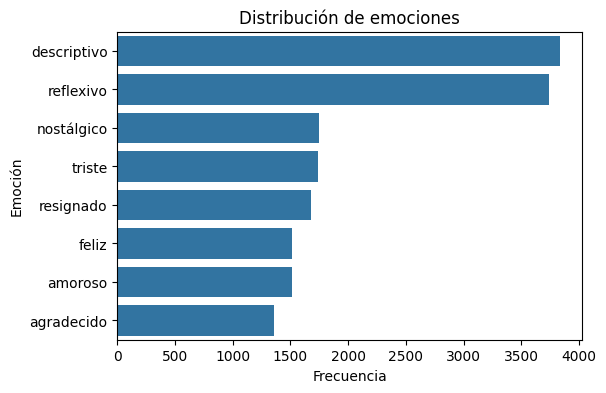

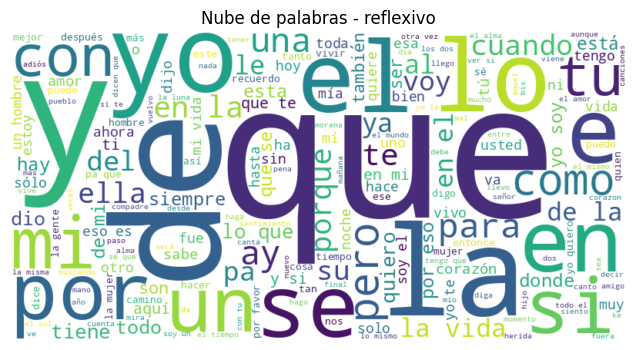

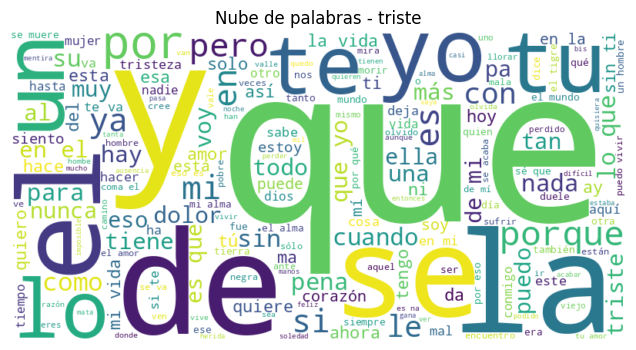

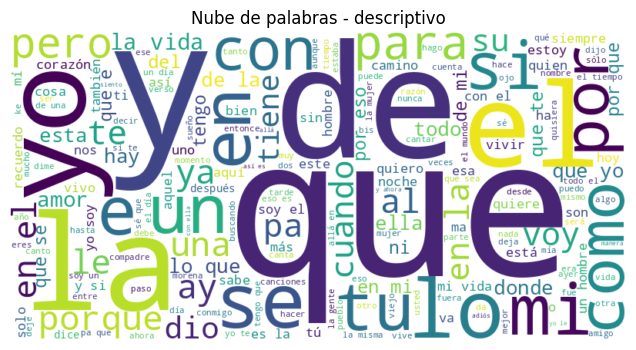

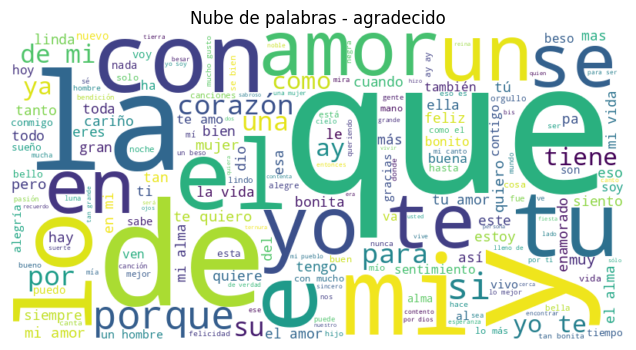

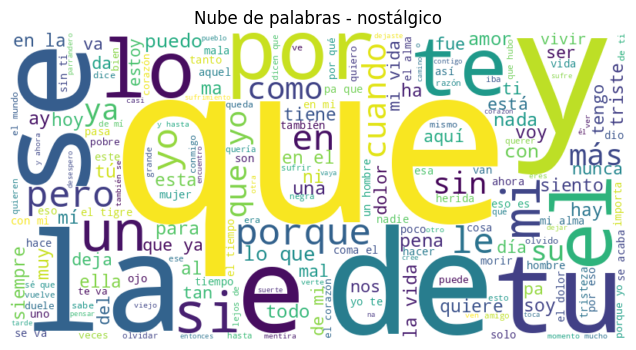

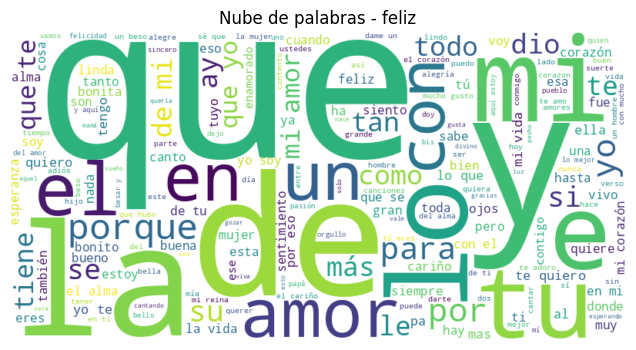

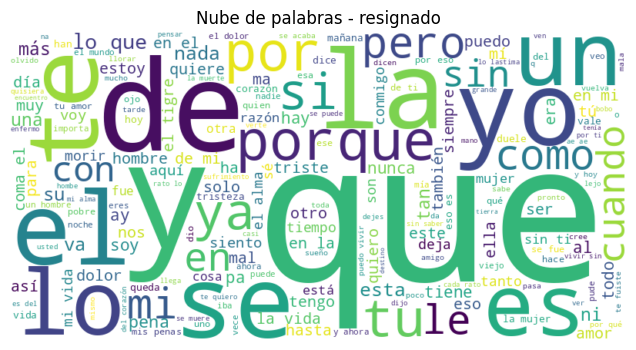

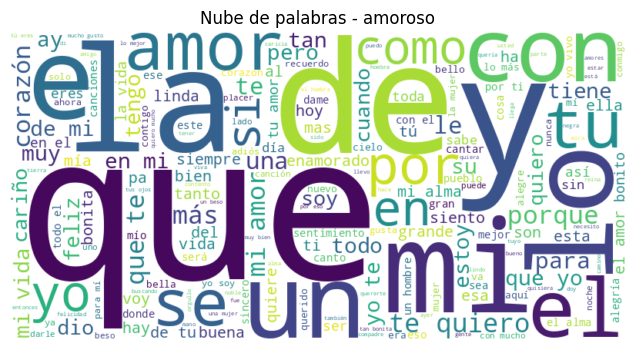

✅ Proceso completado exitosamente.


In [8]:
# VISUALIZACIÓN
plt.figure(figsize=(6,4))
sns.countplot(y=df['sentimiento_emocional'], order=df['sentimiento_emocional'].value_counts().index)
plt.title("Distribución de emociones")
plt.xlabel("Frecuencia")
plt.ylabel("Emoción")
plt.show()

for label in df['sentimiento_emocional'].unique():
    texto_label = ' '.join(df[df['sentimiento_emocional']==label]['linea'])
    nube = WordCloud(width=800, height=400, background_color='white').generate(texto_label)
    plt.figure(figsize=(8,4))
    plt.imshow(nube, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nube de palabras - {label}")
    plt.show()

print("✅ Proceso completado exitosamente.")

In [9]:
df.head(10)

,nombre_cancion,linea,sentimiento_predicho,sentimiento_emocional
0,26 de mayo,el veintiséis del mes de mayo,neutral,reflexivo
1,A mi papá,voy a componé un merengue,neutral,reflexivo
2,A un cariño del alma,cuando se acaban todas las palabras,negativo,triste
3,A un colega,de una manera especial y en una forma correcta,neutral,descriptivo
4,A Un Ladito Del Camino,hoy me siento enamorado,positivo,agradecido
5,Acercate a mí,aquí traigo el corazón todo hecho pedazos,negativo,nostálgico
6,Acompáñame,si estoy tomando no pregunten la razón,neutral,reflexivo
7,Adios lunarcito,cuánto diera por tener,positivo,agradecido
8,Aguila,hoy encontré en el desierto de mi alma,negativo,nostálgico
9,Al final del sendero,yo sentí en el final del sendero,neutral,reflexivo
